# Goals and Overview

The goal of this project is to prepare a prototype of a machine learning model that predicts the amount of gold recovered from gold ore. I will Prepare the data, perform data analysis, and develop and train a model.

# Project

## Initialization

In [1]:
# Loading necessary libraries.
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy import stats as st
from sklearn.dummy import DummyRegressor

## Reading Data

In [2]:
train_df = pd.read_csv('./datasets/gold_recovery_train.csv')
test_df = pd.read_csv('./datasets/gold_recovery_test.csv')
full_df = pd.read_csv('./datasets/gold_recovery_full.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


The training dataset has many features regarding the quantity of resources used and produced throughout the process, as well as parameters of stages. All values seem to be of the appropriate 'float64' datatype, due to quantities of resources being best expressed as real numbers.

There also seems to be missing values for many rows in various columns. This will be explored below.

In [ ]:
test_df.info()

The test dataframe is not as large as the training one, having both fewer rows and columns. Like before, all columns are of the appropriate 'float64' datatype for the same reasons as discussed above.

There is also a variation in the amount of non-null values, and will be explored below.

In [ ]:
full_df.info()

In [ ]:
def recovery_check(df):
    df = df.dropna()
    
    concentrate = df['rougher.output.concentrate_au']
    feed = df['rougher.input.feed_au']
    tail = df['rougher.output.tail_au'] 
    recovery = df['rougher.output.recovery']
    
    calculated_recovery = ((concentrate * (feed - tail)) / (feed * (concentrate - tail))) * 100
    mae = mean_absolute_error(recovery, calculated_recovery)
    
    print(mae)
    return calculated_recovery

In [ ]:
calc_reco = recovery_check(train_df)

Based on the MAE of 9.460144184559453e-15, the recovery values in the train dataframe are very accurate, being very close to exactly the calculated values.

In [ ]:
calc_reco = recovery_check(full_df)

The same applies to the full dataframe.

### Missing Features

In [ ]:
missing_feat = []
for col in train_df.columns:
    if col not in test_df.columns:
        missing_feat.append(col)

print('Missing Features in test_df:')
missing_feat

The test dataframe is missing many features contained in the training dataframe, mainly the output parameters for the various stages of the process as well as a few calculation parameters. Those features will be removed from the training dataframe for the training of the model, as the model will not have those features to make predictions when it comes to the test dataframe.

### Missing Values

In [ ]:
train_df.isna().sum().head(40)

In [ ]:
train_df.isna().sum().tail(46).sort_values(ascending=False)

There is a large amount of missing values in most columns of the train dataframe, with the rougher.output feature having multiple elements missing over 2000 values.

I will begin by dropping missing values, then returning to see if I can fill them in.

In [ ]:
test_df.isna().sum()

The test dataframe has much fewer missing values, with the highest amount missing being 353.

I will begin by dropping missing values, then returning to see if I can fill them in.

In [ ]:
full_df.isna().sum().head(40)

In [ ]:
training_df = train_df.dropna()

In [ ]:
full_dummy = full_df.dropna()

### Duplicate Data

In [ ]:
train_df[train_df.duplicated()]

In [ ]:
test_df[test_df.duplicated()]

In [ ]:
full_df[full_df.duplicated()]

There is no duplicate data to be considered.

## Data Preparation

In [ ]:
test_missing = missing_feat.copy()
test_missing.remove('rougher.output.recovery')
test_missing.remove('final.output.recovery')
print(test_missing)

## Data Analysis

### Change in Concentration

In [4]:
def change_in_concentration(df):
    stage_1_pb = df['primary_cleaner.output.concentrate_pb'] / df['rougher.output.concentrate_pb']
    stage_2_pb = df['final.output.concentrate_pb'] / df['primary_cleaner.output.concentrate_pb']
    
    stage_1_au = df['primary_cleaner.output.concentrate_au'] / df['rougher.output.concentrate_au']
    stage_2_au = df['final.output.concentrate_au'] / df['primary_cleaner.output.concentrate_au']
    
    stage_1_ag = df['primary_cleaner.output.concentrate_ag'] / df['rougher.output.concentrate_ag']
    stage_2_ag = df['final.output.concentrate_ag'] / df['primary_cleaner.output.concentrate_ag']

    return stage_1_pb, stage_2_pb, stage_1_au, stage_2_au, stage_1_ag, stage_2_ag

In [5]:
pb_concentrate = pd.DataFrame()
pb_concentrate['rougher.output.concentrate_pb'] = full_df['rougher.output.concentrate_pb']
pb_concentrate['primary_cleaner.output.concentrate_pb'] = full_df['primary_cleaner.output.concentrate_pb']
pb_concentrate['final.output.concentrate_pb'] = full_df['final.output.concentrate_pb']

pb_concentrate

,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
0,7.101074,10.389648,9.889648
1,7.278807,10.497069,9.968944
2,7.216833,10.354494,10.213995
3,7.175616,8.496563,9.977019
4,7.240205,9.986786,10.142511
...,...,...,...
22711,10.984003,12.445966,11.356233
22712,10.888213,12.623947,11.349355
22713,8.955135,12.633558,11.434366
22714,10.655377,12.012378,11.625587


In [ ]:
ag_concentrate = pd.DataFrame()
ag_concentrate['rougher.output.concentrate_ag'] = full_df['rougher.output.concentrate_ag']
ag_concentrate['primary_cleaner.output.concentrate_ag'] = full_df['primary_cleaner.output.concentrate_ag']
ag_concentrate['final.output.concentrate_ag'] = full_df['final.output.concentrate_ag']

ag_concentrate

In [ ]:
au_concentrate = pd.DataFrame()
au_concentrate['rougher.output.concentrate_au'] = full_df['rougher.output.concentrate_au']
au_concentrate['primary_cleaner.output.concentrate_au'] = full_df['primary_cleaner.output.concentrate_au']
au_concentrate['final.output.concentrate_au'] = full_df['final.output.concentrate_au']

au_concentrate

In [6]:
stage_1_pb, stage_2_pb, stage_1_au, stage_2_au, stage_1_ag, stage_2_ag = change_in_concentration(full_df.dropna())

print("Median change in concentration from Rougher Concentrate to Pb concentrate in 1st Stage:", stage_1_pb.median())
print("Median change in concentration for Pb concentrate in 2nd Stage:", stage_2_pb.median())
print()

print("Median change in concentration from Rougher Concentrate to Ag concentrate in 1st Stage:", stage_1_ag.median())
print("Median change in concentration for Ag concentrate in 2nd Stage:", stage_2_ag.median())
print()

print("Median change in concentration from Rougher Concentrate to Au concentrate in 1st Stage:", stage_1_au.median())
print("Median change in concentration for Au concentrate in 2nd Stage:", stage_2_au.median())
print()

Median change in concentration from Rougher Concentrate to Pb concentrate in 1st Stage: 1.3330650327725844
Median change in concentration for Pb concentrate in 2nd Stage: 0.9639987637924591

Median change in concentration from Rougher Concentrate to Ag concentrate in 1st Stage: 0.7152049083566736
Median change in concentration for Ag concentrate in 2nd Stage: 0.5841103147930776

Median change in concentration from Rougher Concentrate to Au concentrate in 1st Stage: 1.5854269457348003
Median change in concentration for Au concentrate in 2nd Stage: 1.3619804853604403



When examining the concentration levels of various metals across different purification stages, distinct patterns emerge for each metal. In Stage 1, lead (Pb) concentrations show a slight increase, followed by a minimal decrease in Stage 2. Silver (Ag), on the other hand, experiences significant decreases in concentration during both stages. Gold (Au) exhibits notable increases in both stages, with the rise being more prominent in Stage 1.

### Feed Distribution

In [ ]:
mean_feed_size = test_df['rougher.input.feed_size'].mean()
median_feed_size = test_df['rougher.input.feed_size'].median()
std_feed_size = test_df['rougher.input.feed_size'].std()

print(f"Mean: {mean_feed_size}")
print(f"Median: {median_feed_size}")
print(f"Standard Deviation: {std_feed_size}")

In [ ]:
mean_feed_size = training_df['rougher.input.feed_size'].mean()
median_feed_size = training_df['rougher.input.feed_size'].median()
std_feed_size = training_df['rougher.input.feed_size'].std()

print(f"Mean: {mean_feed_size}")
print(f"Median: {median_feed_size}")
print(f"Standard Deviation: {std_feed_size}")

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.histplot(training_df['rougher.input.feed_size'], kde=True, bins=100, color='blue', label='train_df', stat='density')

sns.histplot(test_df['rougher.input.feed_size'], kde=True, bins=100, color='green', label='test_df', stat='density')

plt.title('Distribution of Rougher Input Feed Size')
plt.xlabel('Feed Size')
plt.ylabel('Density')
plt.xlim(20, 100)

plt.legend()

plt.show()

The feed particle size distributions in the training set and in the test set are similar enough for the model to be effective.

### Concentration of Substances

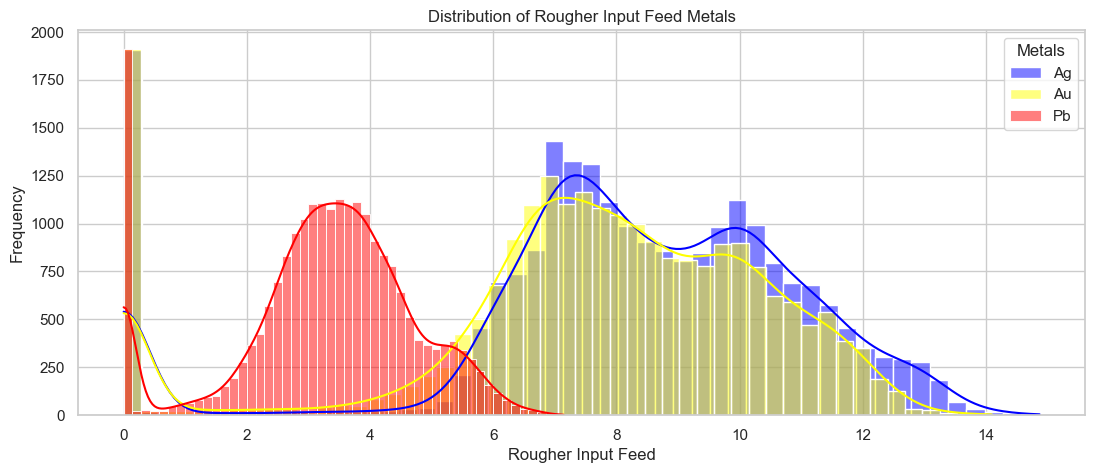

In [7]:
sns.set(style="whitegrid")

plt.figure(figsize=(13, 5))

sns.histplot(full_df['rougher.input.feed_ag'], kde=True, bins=50, color='blue', label='Ag')
sns.histplot(full_df['rougher.input.feed_au'], kde=True, bins=50, color='yellow', label='Au')
sns.histplot(full_df['rougher.input.feed_pb'], kde=True, bins=50, color='red', label='Pb')

plt.title('Distribution of Rougher Input Feed Metals')
plt.xlabel('Rougher Input Feed')
plt.ylabel('Frequency')

plt.legend(title='Metals')

plt.show()

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(13, 5))

sns.histplot(full_df['rougher.output.concentrate_ag'], kde=True, bins=50, color='blue', label='Ag')
sns.histplot(full_df['rougher.output.concentrate_au'], kde=True, bins=50, color='yellow', label='Au')
sns.histplot(full_df['rougher.output.concentrate_pb'], kde=True, bins=50, color='red', label='Pb')

plt.title('Distribution of Rougher Concentrate Metals')
plt.xlabel('Rougher Concentrate')
plt.ylabel('Frequency')

plt.legend(title='Metals')

plt.show()

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(13, 5))

sns.histplot(full_df['final.output.concentrate_ag'], kde=True, bins=50, color='blue', label='Ag')
sns.histplot(full_df['final.output.concentrate_au'], kde=True, bins=50, color='yellow', label='Au')
sns.histplot(full_df['final.output.concentrate_pb'], kde=True, bins=50, color='red', label='Pb')

plt.title('Distribution of Final Concetrate')
plt.xlabel('Final Concetrate')
plt.ylabel('Frequency')

plt.legend(title='Metals')

plt.show()

When analyzing the total concentrations of all substances at different stages, there is a large fequency of values that are 0. These are anomalies that will impact the training negatively and thus will be removed from both the training and test sets.

### Obtaining the SMAPE

In [ ]:
def smape(target, predicted):

    n = len(target)
    if n != len(predicted):
        raise ValueError("The lengths of target and predicted lists must be the same.")
    
    smape_values = []
    for a, f in zip(target, predicted):
        if (abs(a) + abs(f)) == 0:
            smape_values.append(0)
        else:
            smape = abs(f - a) / ((abs(a) + abs(f)) / 2)
            smape_values.append(smape)
    
    return (100 / n) * sum(smape_values)

In [ ]:
def get_final_smape(r,f):
    
    final_smape_value = 0.25 * r + 0.75 * f

    return final_smape_value

## Model Exploration

In [ ]:
training_df.drop(columns=test_missing, inplace=True)

training_df.info()

In [ ]:
training_df.drop(columns=['date'], inplace=True)
training_df

In [ ]:
target1 = training_df['rougher.output.recovery']
target2 = training_df['final.output.recovery']
    
features = training_df.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

In [ ]:
smape_scorer = make_scorer(smape, greater_is_better=False)

In [ ]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(features, target1)
dummy_prediction1 = dummy_regr.predict(features)

dummy_regr.fit(features, target2)
dummy_prediction2 = dummy_regr.predict(features)

smape_rougher = smape(target1,dummy_prediction1)
smape_final = smape(target2,dummy_prediction2)
    
final_smape = get_final_smape(smape_rougher,smape_final)

print("Final sMAPE for model:", final_smape)

In [ ]:
param_grid = {
    'max_depth': [1, 2, 3, 4, 5],
    'splitter': ['best', 'random']
}

dtc_model = DecisionTreeRegressor(random_state=12345)

grid_search = GridSearchCV(dtc_model, param_grid, cv=5, scoring=smape_scorer)

grid_search.fit(features, target1)

best_params = grid_search.best_params_

best_dtc_model = DecisionTreeRegressor(**best_params, random_state=12345)

scores_target1 = cross_val_score(best_dtc_model, features, target1, cv=5, scoring=smape_scorer)
mean_score_target1 = -scores_target1.mean()

scores_target2 = cross_val_score(best_dtc_model, features, target2, cv=5, scoring=smape_scorer)
mean_score_target2 = -scores_target2.mean()

final_smape = get_final_smape(mean_score_target1, mean_score_target2)

print("Mean cross-validation score for target1:", mean_score_target1)
print("Mean cross-validation score for target2:", mean_score_target2)
print("Final sMAPE for model:", final_smape)

In [ ]:
param_grid = {
    'n_estimators': [10, 50],
    'max_depth': [None, 5, 10]
}

rfr_model = RandomForestRegressor(random_state=12345)

grid_search = GridSearchCV(rfr_model, param_grid, cv=3, scoring=smape_scorer, n_jobs=-1)
grid_search.fit(features, target1)

best_rfr_params = grid_search.best_params_

best_rfr_model = RandomForestRegressor(**best_rfr_params, random_state=12345)

scores_target1 = cross_val_score(best_rfr_model, features, target1, cv=3, scoring=smape_scorer, n_jobs=-1)
mean_score_target1 = -scores_target1.mean()

scores_target2 = cross_val_score(best_rfr_model, features, target2, cv=3, scoring=smape_scorer, n_jobs=-1)
mean_score_target2 = -scores_target2.mean()

final_smape = get_final_smape(mean_score_target1, mean_score_target2)

print("Mean cross-validation score for target1:", mean_score_target1)
print("Mean cross-validation score for target2:", mean_score_target2)
print("Final sMAPE for model:", final_smape)

In [ ]:
param_grid = {
    'fit_intercept': [True, False],  
    'normalize': [True, False]  
}

lr_model = LinearRegression()

grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring=smape_scorer)

grid_search.fit(features, target1)

best_params = grid_search.best_params_

best_lr_model = LinearRegression(**best_params)

scores_target1 = cross_val_score(best_rfr_model, features, target1, cv=5, scoring=smape_scorer)
mean_score_target1 = -scores_target1.mean()

scores_target2 = cross_val_score(best_rfr_model, features, target2, cv=5, scoring=smape_scorer)
mean_score_target2 = -scores_target2.mean()

final_smape = get_final_smape(mean_score_target1, mean_score_target2)

print("Mean cross-validation score for target1:", mean_score_target1)
print("Mean cross-validation score for target2:", mean_score_target2)
print("Final sMAPE for model:", final_smape)

After training various models, RandomForestRegressor was the model that performed the best and will be used to make predictions with the test set.

## Final Model

In [ ]:
outputs_df = pd.DataFrame()
outputs_df['date'] = full_df['date']
outputs_df['rougher.output.recovery'] = full_df['rougher.output.recovery']
outputs_df['final.output.recovery'] = full_df['final.output.recovery']
outputs_df

In [ ]:
test_final = test_df.merge(outputs_df, on='date', how='left')
test_final

In [ ]:
test_final = test_final.dropna()
test_final = test_final.drop(columns=['date'])

In [ ]:
f_target1 = test_final['rougher.output.recovery']
f_target2 = test_final['final.output.recovery']
    
f_features = test_final.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

In [ ]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(features, target1)
dummy_prediction1 = dummy_regr.predict(f_features)

dummy_regr.fit(features, target2)
dummy_prediction2 = dummy_regr.predict(f_features)

smape_rougher = smape(f_target1,dummy_prediction1)
smape_final = smape(f_target2,dummy_prediction2)
    
final_smape = get_final_smape(smape_rougher,smape_final)

print("Final sMAPE for model:", final_smape)

In [ ]:
best_rfr_model.fit(features, target1)
predicted1 = best_rfr_model.predict(f_features)
    
best_rfr_model.fit(features, target2)
predicted2 = best_rfr_model.predict(f_features)
    
smape_rougher = smape(f_target1,predicted1)
smape_final = smape(f_target2,predicted2)
    
final_smape = get_final_smape(smape_rougher,smape_final)

#print("Mean cross-validation score:", mean_score)
print("Final sMAPE for model:", final_smape)

In [ ]:
final_predictions_targets = pd.DataFrame()
final_predictions_targets['predicted rougher recovery'] = predicted1
final_predictions_targets['acutal rougher recovery'] = target1

final_predictions_targets['predicted final recovery'] = predicted2
final_predictions_targets['actual final recovery'] = target2
final_predictions_targets

## Conclusion

The model exhibits strong performance with a final sMAPE of 7.2264, indicating accurate predictions. The mean cross-validation sMAPE of 12.2756 suggests that the model's performance is generally robust, although there is some variability between cross-validation and final test performance. The consistency between predictions and actual values in the provided data further supports the conclusion that the model is making reliable predictions. These results imply that the model is well-calibrated and performs well in both cross-validation and final testing scenarios, with better performance observed in the final test set. The relatively low sMAPE values reflect a high level of accuracy in the model's forecasts.